# ACSE-7 (Optimisation & Inversion) <a class="tocSkip"></a>

## Coursework part B <a class="tocSkip"></a>

Part B of the coursework covers lectures 2-7. The completion time should be roughly that of part A and part C combined.

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\boldsymbol{\mathrm{#1}}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
\newcommand\vlam{\boldsymbol{\lambda}}
$

Firstly, in part B of the coursework the code given for the K_matrix actually implements Dirichlet boundary conditions whereas the text suggests Neumann boundary conditions. Question B1 to B7 do not use the code, so you should answer them exactly as they are stated. In questions B8 to B14 the difference between Neumann and Dirichlet boundaries is not relevant, everything that is stated there is true for both Neumann and Dirichlet boundary conditions. So also here you can answer, and implement exactly as it is suggested using the K_matrix function as given.

Finally a hint for part B: if you execute the cell right before question B7 and make up your own value for m, then you will overwrite the file rsm-blurred.npy that was given to you. So when you answer question B10 to find out the unknown value of m, make sure you put back the original rsm-blurred.npy file from the repository, otherwise you will just find your own chosen value back!

In [238]:
# needs to be in separate cell!
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl

from ipykernel import kernelapp as app

# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

## From Poisson to Diffusion Equation <a class="tocSkip"/></a>

In the lectures, we have used a finite difference discretisation of Poisson's equation in two dimensions:

$$
  -\frac{\partial^2 u(x,y)}{\partial x^2} - \frac{\partial^2 u(x,y)}{\partial y^2} = f(x,y)
$$

with a Finite Difference discretisation given by:


$$ \frac{-u_{i-1} + 2u_{i} -u_{i+1}}{\Delta x^2} + \frac{-u_{i-N_x} + 2u_{i} - u_{i+N_x}}{\Delta y^2} = f_i $$

where we assume a computational grid of $N_y$ rows and $N_x$ columns, giving $n=N_x\cdot N_y$ grid points. The grid values $u_i$ are numbered row by row. The values $u_{i-1}$ and $u_{i+1}$ refer to the values to the left and right of $u_i$ respectively, whereas $u_{i-N_x}$ and $u_{i+N_x}$ refer to value in the row above and below. We will assume $\Delta y=\Delta x$. In matrix form we may write

$$
  \mat K \vec u = \vec f
$$

with for each row $i$ associated with a grid point in the interior (away from the boundary):

$$
  K_{i,i} = \frac{4}{\Delta x^2}, \text{ and }
  K_{i,i-N_x} = K_{i,i-1} = K_{i,i+1} = K_{i,i+N_x} = -\frac 1{\Delta x^2}
$$

For the boundary rows, we imposed Dirichlet boundary conditions, and we stated, without proof, that the resulting matrix is Symmetric Positive Definite.

# Question B1

* What is your recommendation for a Krylov Subspace method to solve this linear system. Describe in one or two sentences why this method requires the matrix to be SPD.

***

# Answer B1

**Recommendation :** Conjugent Gradient (CG) method.

**Reasoning :** It is robust (guaranteed to converge), relatively simple, and usually converges much faster than other avaliable methods since the matrix is SPD.

***
**Extra :** 

The CG method is in fact the most powerful method for a certain class of problems based on Symmetric Positive Definite systems.

For SPD matrices the analysis is made simpler by the fact that it is known that there is a complete basis of orthogonal eigenvectors, and that all eigenvalues are strictly positive.

For linear systems based on a SPD matrix, the preconditioned CG method is usually the method of choice. Usually this converges very fast in particular when combined with preconditioning techniques appropriate for the particular problem.

The guarantene to converge is due to having SPD which ensures the denominator does not become zero for computaion of  $\alpha$:
$$
\alpha = \frac{\vec r^{(k)}\cdot\vec r^{(k)}}{\vec r^{(k)} \cdot\underline{\mathbf{A}}\vec r^{(k)}}
$$

In other words, the Conjugate Gradient algorithm is a Krylov subspace method, which like any other such method, chooses  $\vec x^{(k+1)}$  to be in the space   $\vec x^{(0)}+ \mathcal{D_k}$

Thus we can summarize the Conjugate Gradient method as the unique method that chooses $\vec x^{(k+1)}$ in the minimum of $f$ in the subspace $\vec x_0 + \mathcal{D}_k$.

***



# Question B2


Note that for the rows associated with interior points, we have

$$
  \sum_{j=1}^n K_{ij} = 0
$$

i.e. the sum of the entries in each interior row is zero. If we apply Neumann (instead of Dirichlet) boundary conditions, the same is true for all rows: both boundary and interior rows sum to zero.

* Is the matrix with Neumann boundary condition still Symmetric Positive Definite? **Hint:** consider a vector $\vec v$ whose values are all the same: $v_i=C$ for all $i$ with some constant $C$, and compute $\vec v^T\mat K\vec v$. Assuming the matrix is symmetric, and that for all other vectors $\vec v$ we still have $\vec v^T\mat K\vec v\gt 0$, what other term *does* apply to this matrix?

***

# Answer B2

**Defition of SPD:**

A matrix
$\underline{\mathbf{A}}$ that is symmetric and
satisfies $\vec v^T\underline{\mathbf{A}}\vec v \gt 0$ for all
$\vec v$, is defined as Symmetric
Positive Definite (SPD).

A symmetric
$n\times n$-matrix that
satisfies the looser requirement of:

$$
\vec v^T
f''(\vec x) \vec v \ge 0 \;\;\; \text{
for all } \;\;\; \vec v\in{\mathbb{R}}^n
$$

is called Positive
Semi-Definite. Similar to before, an equivalent definition is given by: a real symmetric matrix whose eigenvalues are all zero or positive.

***

The Neumann Boundary Condition can be given as the derivetive of $u$ at the boundaries. This will be approximated using eulerstep method which begins at the boundary node inside our matrix.

Provided are:
* Function:
$$
  -\frac{\partial^2 u(x,y)}{\partial x^2} - \frac{\partial^2 u(x,y)}{\partial y^2} = f(x,y)
$$


* Finite Difference discretisation:

$$ \frac{-u_{i-1} + 2u_{i} -u_{i+1}}{\Delta x^2} + \frac{-u_{i-N_x} + 2u_{i} - u_{i+N_x}}{\Delta y^2} = f_i $$

Now as discussed above, let's apply eulerstep for the non-exsisting entries according the Neumann Boundary Condition (denoted in the function either with $ \frac{\partial u_{i}}{\partial x}$ or $ \frac{\partial u_{i}}{\partial y}$ ). 

Thus the boundries would be as follows with the normal:

* Right:
$$ u_{i+1} = u_{i} + {\Delta x}  * \frac{\partial u_{i}}{\partial x}$$

* Left:
$$ u_{i-1} = u_{i} - {\Delta x}  * \frac{\partial u_{i}}{\partial x}$$

* Top:
$$ u_{i+N_{x}} = u_{i} + {\Delta x}  * \frac{\partial u_{i}}{\partial y}$$

* Bottom:
$$ u_{i-N_{x}} = u_{i} + {\Delta x}  * \frac{\partial u_{i}}{\partial y}$$

Now that the boundries are defined, let's substitute into the given equation for bottom right corner:

$$ \frac{-(u_{i} - {\Delta x}  * \frac{\partial u_{i}}{\partial x}) + 2u_{i} -u_{i+1}}{\Delta x^2} + \frac{-(u_{i} + {\Delta x}  * \frac{\partial u_{i}}{\partial y}) + 2u_{i} - u_{i+N_x}}{\Delta x^2} = f_i $$

Note that, there is a provided assumption that $\Delta y=\Delta x$. 

It is already been given that for Matrix $K$, the sum of all rows is zero but lets prove that:

* Rows @ Corner nodes:

$$K_{ii} = \frac{4}{\Delta x} - \frac{2}{\Delta x} = \frac{2}{\Delta x}$$

$$K_{i,i+1} = K_{i,i-1} = K_{i,i+N_{x}} = K_{i,i-N_{x}} = - \frac{1}{\Delta x^2}$$

* Rows @ Boundary nodes:

$$K_{ii} = \frac{4}{\Delta x} - \frac{1}{\Delta x} = \frac{3}{\Delta x}$$

$$K_{i,i+1} = K_{i,i-1} = K_{i,i+N_{x}} = K_{i,i-N_{x}} = - \frac{1}{\Delta x^2}$$

As defined at the start, in the case of a constant coloumn matrix the Matrix can be defined as semi-SPD as $\vec v^T\underline{\mathbf{K}}\vec v = 0$. On the other hand, for non-constant vector  $\vec v^T\underline{\mathbf{K}}\vec v \gt 0$ will stand true. Thus, we end up with following:

$$
\vec v^T\underline{\mathbf{K}}\vec v \ge 0 \in{\mathbb{R}}^n
$$

Thus, the matrix should be defined as Positive Semi-Definite.

Material learned from: Lecture by MIT from 
Qiqi Wang https://youtu.be/uaBh_ztR_i8
***



# Question B3


By adding a time derivative, we can turn this PDE into the diffusion equation

$$
  \frac{\partial u(x,y,t)}{\partial t} - m \frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2} = 0
$$

with diffusion coefficient $m$.

With an implicit time integration (backward Euler) the discrete equation looks like:
    
$$ 
\frac{u_i^{k+1} - u_i^k}{\Delta t} +
m\frac{-u_{i-1}^{k+1} + 2u_{i}^{k+1} -u_{i+1}^{k+1}}{\Delta x^2} + m\frac{-u_{i-N_x}^{k+1} + 2u_{i}^{k+1} - u_{i+N_x}^{k+1}}{\Delta y^2} = 0 $$

where the superscript ${}^{k+1}$ refers to the solution at the end of the timestep, and ${}^k$ to the value at the beginning of the timestep.

After multiplying all terms with $\Delta t$, we can write this discretisation as a linear system

$$
  \mat A \vec u^{k+1} = \vec u^k
$$

where the matrix $\mat A$ is given by

$$
  \mat A = \mat I + m~\Delta t~\mat K
$$

with identity matrix $\mat I$, and $\mat K$ the same matrix as we used for Poisson's equation above with Neumann conditions.

* Using what you already know about $\mat K$, proof that $\mat A$ is Symmetric Positive Definite.

***

# Answer B3

In the previous question, we proved that matrix $K$ is a Symmetric Positive Semi-Definite. 

Multiplying the Matrix $K$ with the term $m{\delta t}$ does not change the properties of the matrix. When it is multiplied by the values inside the matrix, the sum of all rows still remain zero. Thus following statement remais correct, 

$$ \vec v^T ( m~\Delta t~\mat K) \ge 0 $$

However, the equation also requires the addition of the identity matrix $I$. Hence, increasing the values in $K$ along the main diagonal. Thus, we end with values being one (1). The term becomes:

$$ \vec v^T (I + m~\Delta t~\mat K) \gt 0 $$

This satisfies the condition described in previous section, so $A$ is SPD.

***

# Question B4

* We consider the use of dense vs. sparse matrices in solving this system. We use the Conjugate Gradient method to solve the linear system above on a series of computational grids where we increase the resolution and thus the number of grid points $n=N_x\cdot N_y$. We record the average time the CG method takes to perform a single iteration with the results displayed in the graph below. Describe the difference in terms of scaling for the case with dense matrices and the case with sparse matrices, and explain the reason why these differences can be observed. You only need to describe the asymptotic behaviour.

<img src='graph1.png'></img>

***

# Answer B4

For a **Dense** matrix, the matrix-vector product will be the dominant term, so one iteration as a whole is $O(n^2)$. We also know that Conjugate Gradient is guaranteed to converge in $n$ iterations, so the algorithm as a whole is $O(n^3)$.

The most expensive operation in a CG iteration is the matrix-vector multiplication. For many cases this operation can be made a lot faster by using the fact that most entries of the matrix are in fact zero (e.g converting to Sparse Matrix). These entries can simply be skipped since their multiplication with entries of the vector has no contribution to the product.

For **Sparse** matrix, the vector multiplication is much faster. In particular it is now a $O(n)$ operation instead of $O(n^2)$. This means the full Conjugate Gradient algorithm with $n$ iterations becomes just $O(n^2)$ instead of $O(n^3)$.

Another important advantage of using more compact matrix format is that it requires less memory to store.

***


# Question B5

* As a stopping criterion we use a relative tolerance $\epsilon_{\text{rel}}=10^{-5}$. In the next two figures, we show the overall time for the Conjugate Gradient algorithm to converge with that criterion, and the number of iterations it takes. Only the results with a sparse matrix are shown. Again describe and explain the asymptotic behaviour of both graphs. You do not need to explain the specific value of the~ slope of 0.5 in the right-hand figure. Given that we can observe a slope of 0.5 however, what is your expectation of the scaling between the condition number of the matrix and $n$? 




<img src="graph2.png"></img>

***

# Answer B5

**Expectation:** the condition number of the matrix to rise with the complexity of $O(\sqrt{n})$. This means that condition of matrix A gets better with increasing n.

Computation time can be calculated by multiplying the time taken for one (1) CG iteration by the number of iterations required to reach the set tolerance threshold:

$$ O(CG) = O(single.iter) * O(no.iter)$$

In previous answer, we detailed that Conjugent Gradient for a sparse matrix has a complexity of $O(n)$. Also, it can be interpreted from the 0.5 slope of the graph that $\sqrt{n}$ no of CG iterations are required to reach the tolarance threshold. A complexity of $O(n^{0.5})$.

Hence, on the logarithmic scale it is shown as a slope of 1.5:

$$ O(CG) = O(n) * O(n^{0.5})$$
***

# Question B6

* We also measured the computational time for solving the linear system with a sparse direct method (not shown). We notice that the scaling of the computational time with the problem size $n$ was worse that linear. Explain why this is to be expected. Do you expect the scaling to be better, the same, or even worse when solving the same equation in three dimensions? Explain why.

***

# Answer B6

**Direct methods**, as opposed to iterative methods, for linear problems are methods that explicitly construct the inverse of the matrix, or a decomposition of the matrix that is easy to invert (e.g. LU-decomposition).

The performance of direct methods can also be improved by taking the sparsity of the matrix into account but this is more complex. Each row operation on its own is initially much cheaper and there are only a limited number of entries to work on. However, after some operations, the matrix will acquire new nonzero entries causing a **fill-in** issue thus slowly the matrix starts becomes dense. Consequently, Direct methods can not exploit the sparsity efficiently, due to the cost of computation converging to that of dense matrices. In 3D, the amount of fill-in (extra non zero entries) is larger, due to memory problems the direct solver will perform poorly or even fail.

**Conclusion**: Whether direct methods or iterative methods are more efficient is thus very problem specific. In general, for many 2D discretised problems, direct methods can be competitive, but in 3D discretisations iterative methods are typically much more efficient.

*Read Material:*

Page 57 from Fluid Simulation for Computer Graphics By Robert Bridson

Lecture from https://www-users.cselabs.umn.edu/classes/Spring-2019/csci8314/FILES/LecN6.pdf



***


# Diffusion Equation as Image Filter (background section - no question) <a class="tocSkip"></a>
The diffusion equation has many applications uch as the dispersal of microparticles through random motion (Brownian motion), the spread of a disolved substance, e.g. a pollutant in a fluid, or the spread of heat. We can also use it as a method to apply a blur effect to a photo.

First we read in a familiar looking photo:

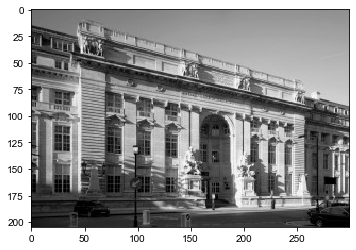

In [124]:
img = plt.imread("RSM-BW-300x205.png")
plt.imshow(img, cmap='gray');

The code to assemble the matrix $\mat A$ is given by:

In [125]:
def K_matrix(Nx, Ny, delta_x=1.0):
    """Assemble discrete Poisson matrix K
    
    Nx, Ny: number of gridpoint in x and y directions
    delta_x: grid distance
    """
    n = Ny * Nx
    K = sp.eye(n)*4  # main diagonal with the value 4
    K -= sp.eye(n, k=1)  # connections to grid point on the right
    K -= sp.eye(n, k=-1)  # connection to the left
    K -= sp.eye(n, k=Nx) # connection to grid point below
    K -= sp.eye(n, k=-Nx)  # connection above
    K = K / (delta_x)**2  # divide all entries by dx^2
        
    return K

def A_matrix(Nx, Ny, m, delta_t=1.0, delta_x=1.0):
    """Assemble discrete timestepping matrix A for diffusion equation
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient
    delta_t: time step
    delta_x: grid distance
    """
    n = Ny * Nx
    K = K_matrix(Nx, Ny, delta_x)
    A = sp.eye(n) + m * delta_t * K
        
    return A

So that a simple timestepping model takes the form:

In [126]:
def diffusion_model(Nx, Ny, m, u0, Nt, delta_t=1.0, delta_x=1.0):
    """Solve diffusion equation and return solution in final timestep
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    """

    A = A_matrix(Nx, Ny, m, delta_t=delta_t, delta_x=delta_x)
    u = u0
    for i in range(Nt):
        u = spl.spsolve(A, u)  # solve using sparse direct solver
    return u

In the rest of this coursework, we simply assume a fixed value for $\Delta x=1$, and also a timestep of $\Delta t=1$. The domain is assumed to be $[0,L]\times [0,H]$ with length $L=N_x\Delta x=N_x$ and height $H=N_y\Delta x=N_y$. The number of timesteps is given by $N_t$, and in the examples kept fixed at $N_t=5$, and we assume that the time $t$ runs between 0 and $T=N_t\Delta t=N_t$.

The code below shows how the diffusion model can be applied to a black and white photo. Note that we need to flatten the `img` array, which has a shape of $N_y\times N_x$, to a flat array `u` with length $n=N_x\cdot N_y$:

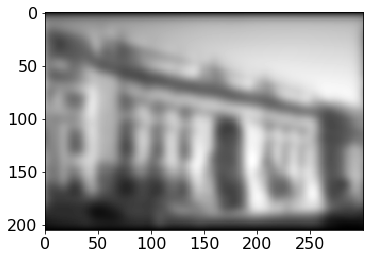

In [6]:
## --- DO NOT RUN ---
Ny, Nx = img.shape
Nt = 5
m = ???  # what value did we use ? PI
u0 = img.flatten()
u1 = diffusion_model(Nx, Ny, m, u0, Nt)
img1 = u1.reshape(Ny, Nx)
plt.imshow(img1, cmap='gray')
np.save('rsm-blurred.npy', img1)

# Question B7

## Inversion for Diffusion Coefficient <a class="tocSkip"/></a>
After applying the diffusion model, we have forgotten what value of the diffusion coefficient $m$ we have used. We do however still have the original photo that was used which served as the initial condition $u_{\text{ic}}$, and the blurred photo obtained from the last timestep value of $u$, which we have stored as $u_{\text{end}}$ (in the file `rsm-blurred.npy`). We therefore consider the following PDE-constrained optimisation problem:

$$
  \text{minimize } f(u, m) = \int \left(u(x, y, T) -u_{\text{end}}(x, y, T)\right)^2 \mathrm{d}x\mathrm{d}y
$$

subject to the PDE constraint:

$$
  g(u,m) = \begin{pmatrix}
    \frac{\partial u(x,y,t)}{\partial t} -m\frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2}  \\
    u(x, y, 0) - u_{\text{ic}}(x, y) \\
    \frac{\partial u(x,y,t)}{\partial x}  \\
    \frac{\partial u(x,y,t)}{\partial y} 
  \end{pmatrix}
  =
  \begin{pmatrix} 
  \phantom{\frac{\partial^2}{\partial x}} 0 \phantom{\frac{\partial^2}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} \\
  \phantom{\frac{\partial u}{\partial x}} 0 \phantom{\frac{\partial u}{\partial x}} 
  \end{pmatrix}
  \begin{array}{l}
\text{ for } (x,y)\in [0,L]\times[0,H], t \in [0,T] \phantom{\frac{\partial^2}{\partial x}} \\
\text{ for } (x,y)\in [0,L]\times[0,H] \phantom{\frac{\partial u}{\partial x}} \\
    \text{ for } x=0\text{ or x=L, and } y\in [0,H], t \in [0,T] \phantom{\frac{\partial u}{\partial x}} \\
    \text{ for } y=0\text{ or y=H, and } x\in [0,L], t \in [0,T]
  \end{array}
$$

* We decide to use the tangent-linear approach to compute the gradient of the reduced functional. Consider a perturbation $\delta m$ in the diffusion coefficient $m$, show that the resulting perturbation $\delta u(x,y,t)$ to the solution $u(x,y,t)$ satisfies the following PDE:

$$
      \frac{\partial \delta u(x,y,t)}{\partial t} -m\frac{\partial^2 \delta u(x,y,t)}{\partial x^2} - m\frac{\partial^2 \delta u(x,y,t)}{\partial y^2} =
      \delta m\frac{\partial^2 u(x,y,t)}{\partial x^2} + \delta m\frac{\partial^2 u(x,y,t)}{\partial y^2}      
$$

with initial condition

$$
  \delta u(x,y,0) = 0
$$

and boundary conditions

\begin{align*}
    \frac{\partial \delta u(x,y,t)}{\partial x} &= 0 & \text{ for } x=0\text{ or x=L, and } y\in [0,H] \\
    \frac{\partial \delta u(x,y,t)}{\partial y} &= 0 &
    \text{ for } y=0\text{ or y=H, and } x\in [0,L]
\end{align*}

***

# Answer B7


**Theory:** For Tangent Linear approach solve:

$$
  \frac{\partial g}{\partial u}\delta u = -\frac{\partial g}{\partial m}\delta m
$$

to obtain the perturbation $\delta u$ in $u$ due to a perturbation $\delta m$ in $m$.

$$
  \delta u = \frac{du}{dm} \delta m
$$

***

Now, let's begin solving

* \begin{align*}
    \frac{\partial g}{\partial u}\delta u 
    =  \frac{\partial}{\partial u}   (u(x,y,0) - u_{ic}(xy))  \delta u \\ = \delta u (x,y,0)
\end{align*}

<br/>

* \begin{align*}
    - \frac{\partial g}{\partial m}\delta m =  -\frac{\partial}{\partial m}   (m-m_{ic})  \delta m \\ = \delta m (x, y, 0)
\end{align*}

<br/>

* \begin{align*}
    \frac{\partial g}{\partial u}\delta u =  \frac{\partial}{\partial u}(\frac{\partial u}{\partial x}) \delta u  \\ = \frac{\partial \delta u}{\partial x} = 0
\end{align*}

<br/>

* \begin{align*}
    - \frac{\partial g}{\partial m}\delta m =  - \frac{\partial}{\partial m}(\frac{\partial m}{\partial y}) \delta m \\ = - \frac{\partial \delta m}{\partial y} = 0
\end{align*}

<br/>

Now, solve for $\frac{\partial g}{\partial u}\delta u = -\frac{\partial g}{\partial m}\delta m$: 

* \begin{align*}
 \frac{\partial g}{\partial u}\delta u =  \frac{\partial}{\partial u} ( \frac{\partial u}{\partial t} - m  \frac{\partial^2 u}{\partial x^2} - m  \frac{\partial^2 u}{\partial y^2}) =  \frac{\partial \delta u}{\partial t} - m \frac{\partial^2 \delta u}{\partial x^2} - m \frac{\partial^2 \delta u}{\partial y^2}
\end{align*}

<br/>

* \begin{align*}
  -\frac{\partial g}{\partial m}\delta m =  - \frac{\partial}{\partial m} ( \frac{\partial u}{\partial t} - m  \frac{\partial^2 u}{\partial y^2} - m  \frac{\partial^2 u}{\partial x^2}) =  \delta m \frac{\partial^2 u}{\partial x^2} +  \delta m \frac{\partial^2 u}{\partial y^2}
\end{align*}

*Thus we end up with:* 

* \begin{align*}
\frac{\partial \delta u}{\partial t} - m \frac{\partial^2 \delta u}{\partial x^2} - m \frac{\partial^2 \delta u}{\partial y^2} = \delta m \frac{\partial^2 u}{\partial x^2} +  \delta m \frac{\partial^2 u}{\partial y^2}
\end{align*}

Note: ${\delta u(x,y,t)}$ has been abbreviated to just $\delta u$

with initial condition

$$
  \delta u(x,y,0) = 0
$$

and boundary conditions

\begin{align*}
    \frac{\partial \delta u(x,y,t)}{\partial x} &= 0 & \text{ for } x=0\text{ or x=L, and } y\in [0,H] \\
    \frac{\partial \delta u(x,y,t)}{\partial y} &= 0 &
    \text{ for } y=0\text{ or y=H, and } x\in [0,L]
\end{align*}

***

# Question B8



Note that the PDE for $\delta u$ is very similar to the PDE for $u$, except for the additional right-hand side term. We can therefore implement it using

$$
  \mat A \vec{\delta u}^{k+1} = \vec{\delta u}^k - \Delta t~\delta m~\mat K\vec u^{k+1}
$$

where $\vec{\delta u}^{k+1}$ and $\vec{\delta u}^k$ are the numerical solutions for $\delta u$ at the end and beginning of the timestep, and $\vec{u}^{k+1}$ is the numerical solution for $u$ at the end of timestep $k$, calculated as before. The code is given by:

In [127]:
def tangent_linear_model(Nx, Ny, kappa, u0, Nt, delta_t=1.0, delta_x=1.0, delta_m=1.0):
    """Solve tangent linear model based on perturbation in diffusion coefficient.
    Return perturbation in final timestep solution
    
    Nx, Ny: number of gridpoint in x and y directions
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    delta_m: perturbation in diffusion coefficient m. Set to 1 to compute gradient (see explanation below)
    """

    K = K_matrix(Nx, Ny, delta_x=delta_x)
    A = A_matrix(Nx, Ny, kappa, delta_t=delta_t, delta_x=delta_x)
    u = u0
    du = np.zeros_like(u)  # initial condition for perturbation du
    for i in range(Nt):
        u = spl.spsolve(A, u)  # solve u as before
        du = spl.spsolve(A, du-delta_t*delta_m*(K @ u))  # solve perturbation du
    return du

Using the `diffusion_model` code we can compute the solution $\vec u(m)$ for any value  of the diffusion coefficient $m$, and using the `tangent_linear_model` function we can compute the derivative $\mathrm{d}\vec u(m)/\mathrm{d}m$ by setting $\delta m=1$:

$$
  \delta u = \frac{\mathrm{d}\vec u(m)}{\mathrm{d}m} \delta m
$$

In [128]:
img = plt.imread("RSM-BW-300x205.png")
Ny, Nx = img.shape
Nt = 5
u0 = img.flatten()

def u(m):
    """Solve diffusion equation using diffusion coefficient m. 
    Keep all other inputs fixed (Nx, Ny, delta_x=1, Nt=5, etc)"""
    u1 = diffusion_model(Nx, Ny, m, u0, Nt)
    return u1

def dudm(m):
    """Compute gradient of solution u wrt diffusion coefficient m. Keep all other inputs fixed
    Keep all other inputs fixed (Nx, Ny, delta_x=1, Nt=5, etc)"""
    du = tangent_linear_model(Nx, Ny, m, u0, Nt)
    return du

Note that we keep all other inputs, like the initial condition, and the number of timesteps fixed.

* Write a test that verifies that the gradient `dudm` computed using the tangent linear model is correct. You may reuse code from the lecture notes, but be aware that $m$ is just a single scalar and not an array, so you may have to adjust the code.

***

# Answer B8

In [131]:
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.optimize as sop

def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0 #.copy deleted
    residuals = []
    h_all = []
    # calculate f(x) here as constant 
    dfdx = grad_f(x)
    for i in range(max_iter):
        r = f(x + h) - f(x) - (dfdx * h)
        residuals.append(sl.norm(r))
        h_all.append(abs(h)) #no need for norm
        h /= 2.
        
    ycor = max(residuals)/30 - min(residuals)
    xcor = max(h_all)/10 - min(h_all)
    
    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(h_all, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((xcor, ycor), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

-- 0 --  m =  0.5435695867548618  dx =  0.007608606357762205
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.99360621 1.99678998 1.99839169 1.99919501 1.9995973  1.9997986
 1.99989928 1.99994955 1.99997457]
-- 1 --  m =  1.8732947656272447  dx =  0.009166446078649988
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.99785311 1.99892508 1.9994622  1.99973109 1.99986532 1.99993418
 1.99997194 1.9999802  2.00015274]
-- 2 --  m =  2.1203865066588112  dx =  -0.005829792551929625
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[2.00121091 2.00060499 2.00030235 2.00015096 2.00007517 2.00003904
 2.00001155 1.99999845 1.99994101]


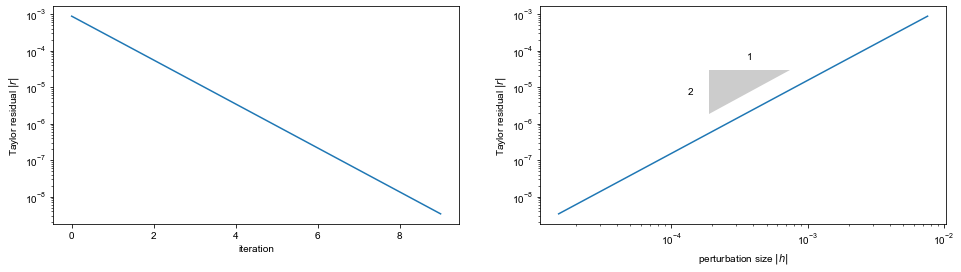

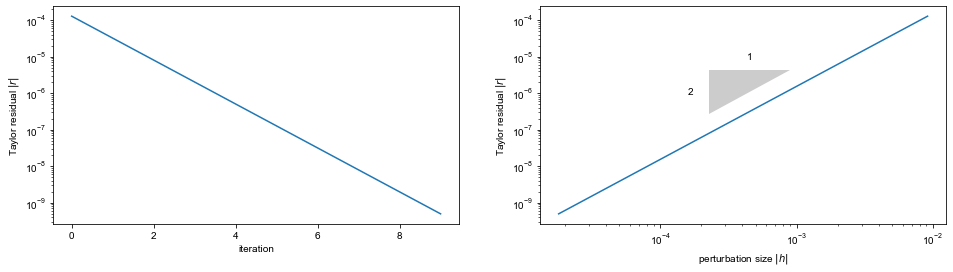

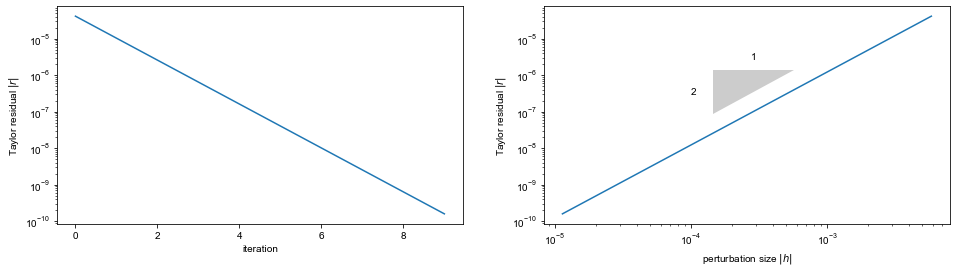

In [132]:
# generating random numbers to check if it works for any condition
m = []
dx = []
for i in range(0, 3):
    m.append(np.random.random() * 10)
    dx.append((np.random.random() - 0.5) * 0.02)

#let's see if the results are correct for 3 random tests
for i in range(0, len(m)):
    print("--", i, "--", " m = ", m[i], " dx = ", dx[i]) #seperator
    taylor_test(u, dudm, m[i], dx[i], max_iter=10, plot_convergence=True, print_convergence=True)


# Question B9


The discrete version of the functional is given by:

$$
  f(\vec u) = \left(\vec u - \vec u_{\text{end}}\right)^T \left(\vec u - \vec u_{\text{end}}\right)
$$

and implemented below:

In [73]:
img1 = np.load('rsm-blurred.npy')
u_end = img1.flatten()

def f(u):
    """Functional, return l2norm error (misfit) between final timestep solution u and u_end"""
    return (u-u_end) @ (u-u_end)

we also define a little helper function that computes $f(\vec u(m))$:

In [74]:
def fhat(m):
    """Reduced functional, for given m evaluate the diffusion model to get u(m), and subtitute in functional."""
    return f(u(m))

* Write a python function `dfdm` that computes:
$$
  \frac{\mathrm{d}f(\vec u(m))}{\mathrm{d}m} = \left.\frac{\partial f(\vec u)}{\partial\vec u}\right|_{\vec u=\vec u(m)}\cdot\frac{\mathrm{d}\vec u}{\mathrm{d}m}
$$
Write a test that verifies the gradient is correct.

***

# Answer B9

..dfdm computed ⟶  25.774226632970716
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[ 2.00045738  2.00023017  2.00012213  2.0000578   2.00012105  1.999852
  2.00065832  2.00337561  1.99596366  2.11932807  1.5412792   2.14329272
  1.96346265 -1.43594637 -1.23858514  2.14699566  0.19600659 -1.17870055
 -0.34419996]


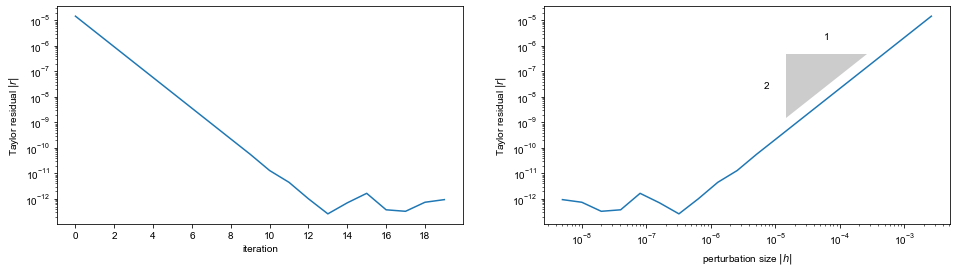

In [38]:
def dfdu(m):
    return 2*(u(m)-u_end)

def dfdm(m):
    return dfdu(m) @ dudm(m)

m = np.random.random() * 10
dx = (np.random.random() - 0.5) * 0.02

#checking for a possible error here 
if not len(dfdu(m)) == len(dudm(m)):
    print("sizes do not match")

print("..dfdm computed ⟶ ", dfdm(m))

# if the gradient still remains the same, the writen code is correct
check = taylor_test(fhat, 
                    dfdm, 
                    m, 
                    dx, 
                    max_iter=20, plot_convergence=True, print_convergence=True)


# Question B10

We decide to use the following minimisation algorithm:

In [75]:
def dfdm(m):
    return dfdu(m) @ dudm(m)

def optimize(dfdm, m0):
    """Algorithm to find stationary point for f(m) by solving df(m)/dm=0
    
    dfdm: a function that returns the gradient of f
    m0: initial guess"""
    
    m_i = m0
    for i in range(100):  # fixed number of maximum iterations
        gradf_i = dfdm(m_i)
        # stopping criterion
        if abs(gradf_i) < 1e-5:
            break
        
        if i>0:
            # approximate the second derivative:
            hess = (gradf_i - gradf_prev) / (m_i - m_prev)
        else:
            # first step: no good approximation, but value should be
            # large enough to ensure the initial step is small
            hess = 100.
        
        # store previous values:
        gradf_prev = gradf_i
        m_prev = m_i
            
        # update step:
        m_i = m_prev - gradf_i/hess
        print('Iteration {}, value: {}'.format(i, m_i))
    else:
        print('Maximum number of iterations reached!')
        
    return m_i

* What is the specific name of the algorithm above, a variant of the Newton method? Why can we not use the standard Newton method? Use the above code to find the value of $m$ that was used to blur the photo. You will find that your initial guess needs to be roughly between 1 and 5. The algorithm does not converge for many values outside that range. Is this to be expected, and how could we improve it? (You do not need to actually implement this improvement)

# Answer B10

**Name of the algorithm:** Quasi-Newton Secant

**Reasoning:** When $F'$ is expensive to calculate, secant’s method is used to approximate the derivative. The derivation of this method comes by using the difference of the two last evaluations of $F$: 

$$
  F'(x^{(i)}) \approx  \frac{F(x^{(i)}) - F(x^{(i-1)})}{x^{(i)}-x^{(i-1)}}
$$

which matches the algorithm used in the "hess" definition of the code.


**Expectation:** Trust region methods limit the area in which the quadratic approximation of 𝑓 that underlies the method is trusted based on a sufficient decrease criterion. It will apply the method unaltered if the quadratic model is good. This will be the case if we're close enough to a local minimum, thus giving us the same local convergence as Newton's method. If we are far away from the minimum, the quadratic model may only be accurate in the near vicinity of the current guess. Hence, the code above only yields correct answer when the initial guess (trust region) is between given range of 1 and 5.

Graph generated below also confirms that the local minumum lies somewhere between 1 and 5, with 3 looking like a good guess to start with. 

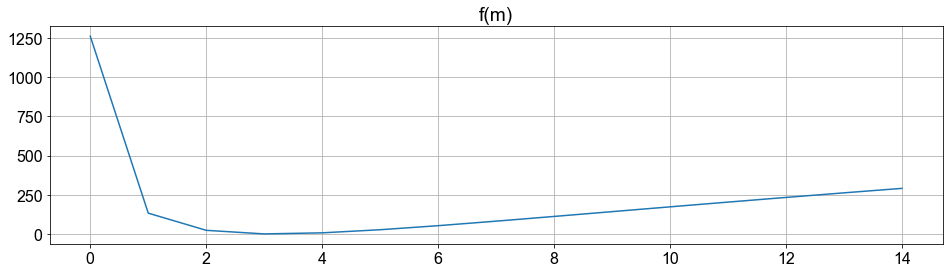

In [76]:
x = range(15)
y1 = []
for m in x:
    y1.append(fhat(m))
    
fig, ax = plt.subplots(1, figsize=(16,4))
ax.set_title('f (m)')
ax.plot(x,y1)
plt.grid()
plt.show()

**Improvement:** Another alternative iterative method of finding the local minumum of the function is *Line Search*. This approach initially finds a direction of descent along where our function $F$ will be reduced and then calculate a step size (how far it will move alonge the direction). There are a few methods of line search to choose from such as a backtracking line search or using the Wolfe conditions.

Useful video: https://youtu.be/uo2z0AT_83k

Read article: http://www.cas.mcmaster.ca/~cs4te3/notes/LineSearchMethods.pdf

https://en.wikipedia.org/wiki/Line_search

In [44]:
# finding m which seems can be deducted to be closer to 3 in the given range 
m = optimize(dfdm, 3)

Iteration 0, value: 3.036663146967891
Iteration 1, value: 3.1353443863697033
Iteration 2, value: 3.1413113876135905
Iteration 3, value: 3.1415892534539007
Iteration 4, value: 3.1415899998214685


In [45]:
#recreating the given image with the computed m 
Ny, Nx = img.shape
Nt = 5
u0 = img.flatten()
u1 = diffusion_model(Nx, Ny, m, u0, Nt)
img2 = u1.reshape(Ny, Nx)

print("Is given image the same as the new one ? ⟶ ", np.allclose(img1, img2))

Is given image the same as the new one ? ⟶  True


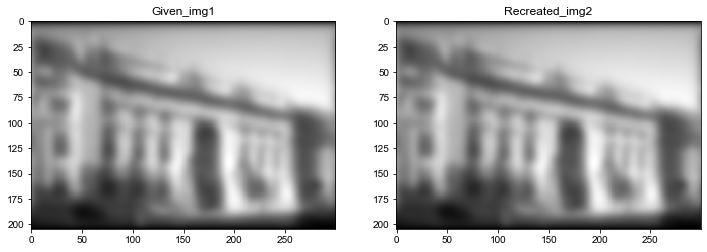

In [46]:
# This is the given image and it can visually confirmed that it looks exactly the 
# same as img2 which is the recreation
img1 = np.load('rsm-blurred.npy')
fig, ax = plt.subplots(1,2, figsize=(12,24))
ax[0].set_title('Given_img1')
ax[0].imshow(img1, cmap='gray')
ax[1].set_title('Recreated_img2')
ax[1].imshow(img2, cmap='gray')

# Question B11

## Variable Diffusion Coefficient <a class="tocSkip"></a>
To apply a blur effect that varies throughout the photo, we consider a spatially varying diffusion coefficient $m(x,t)$

$$
  \frac{\partial u(x,y,t)}{\partial t} - m(x,t) \frac{\partial^2 u(x,y,t)}{\partial x^2} - m\frac{\partial^2 u(x,y,t)}{\partial y^2} = 0
$$

or in discretised form:
    
$$ 
\frac{u_i^{k+1} - u_i^k}{\Delta t} +
m_i\frac{-u_{i-1}^{k+1} + 2u_{i}^{k+1} -u_{i+1}^{k+1}}{\Delta x^2} + m_i\frac{-u_{i-N_x}^{k+1} + 2u_{i}^{k+1} - u_{i+N_x}^{k+1}}{\Delta y^2} = 0 $$

where $m_i$ are the entries of a vector $\vec m$ storing the different values of the diffusion coefficient at the grid points.

Again, we can write this as a linear system

$$
  \mat A \vec u^{k+1} = \vec u^k
$$

where now

$$
  \mat A = \mat I + \Delta t~\mat{diag}(\vec m)~\mat K
$$

with $\mat{diag}(\vec m)$ the diagonal matrix whose only nonzero entries are along the main diagonal, and are given by the entries of $\vec m$.

The implementation is given below:

In [166]:
def A_matrix(Nx, Ny, m, delta_t=1.0, delta_x=1.0):
    """Assemble discrete timestepping matrix A for diffusion equation
    with variable diffusion
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    delta_t: time step
    delta_x: grid distance
    """

    n = Ny * Nx
    K = K_matrix(Nx, Ny, delta_x)
    A = sp.eye(n) + delta_t * sp.diags(m) @  K
        
    return A

* Show that the matrix $\mat A$ is *not* symmetric (either by mathematical proof or by experiment), assuming the values of $\vec m$ are not all the same.

# Answer B11

The written code bellow proves experimentely that matrix $\mat A$ is *not* symmetric under the assumption that the values of $\vec m$ are not all the same. 

The experiment does this through first checking if the transpose of the matrix the is the same as the given matrix under a given tolerance. Also, graphing the matrix and its transpose side by side for visual confirmation.

Matrix A symmetric? ⟶  False


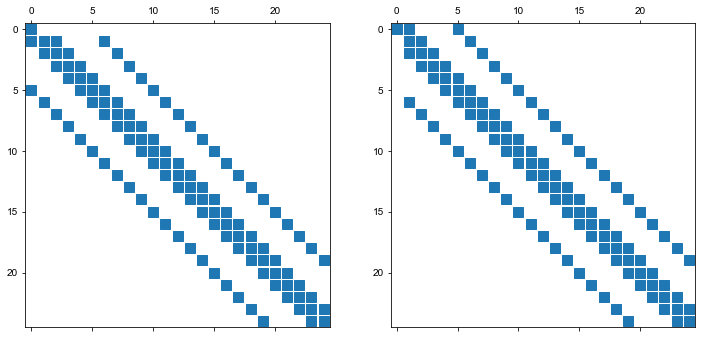

In [167]:
# construct the A matrix
Nx = Ny = 5
m = np.arange(0, Nx*Ny)
A = A_matrix(Nx, Ny, m)

#numerical check
def is_symm(M, tol=1e-08):
    return np.all(np.abs(M-M.T) < tol)

print("Matrix A symmetric? ⟶ ", is_symm(A.todense()))

#graph for experimental analysis
fig, ax = plt.subplots(1,2, figsize=(12,24))
ax[0].spy(A)
ax[1].spy(A.T)

# Question B12

We now need to redefine the `diffusion_model` based on the new `A_matrix`. This code works exactly as before, except we now return not just the solution at the last timestep, but also all inbetween solutions in a list:

In [168]:
def diffusion_model(Nx, Ny, m, u0, Nt, delta_t=1.0, delta_x=1.0):
    """Solve diffusion equation with variable diffusion,
    and return the solution in all timesteps
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    u0: initial condition
    Nt: number of timesteps
    delta_t: time step
    delta_x: grid distance
    """

    A = A_matrix(Nx, Ny, m, delta_t=delta_t, delta_x=delta_x)
    u = []
    ui = u0
    for i in range(Nt):
        ui = spl.spsolve(A, ui)
        u.append(ui)
    return u

We use the model on a different photo, and run the model to apply the blurring effect.

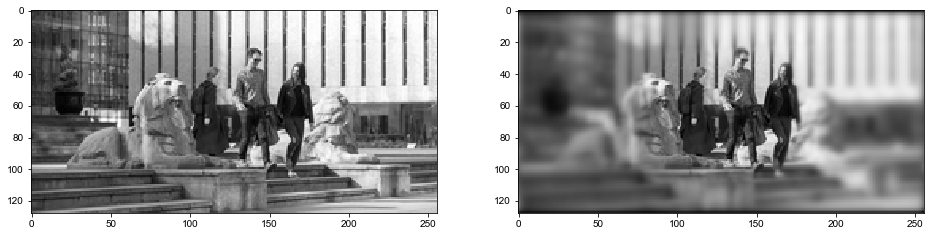

In [169]:
# read the input image, which forms the initial condition u_ic:
img = plt.imread('queens.png')
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(img, cmap='gray')

# This sets up the  spatially varying diffusion coefficient in an array m
# that increases towards the boundaries
# However, after this cell we will "forget" what m was, and try to retreive it
# by solving the optimisation problem described further below
Ny, Nx = img.shape
x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
x0 = Nx/2.; y0 = Ny/2.
m_grid = np.exp(-1/100./(((x-x0)/Nx/0.75)**4+((y-y0)/Ny/1.2)**4+1e-10))
m = m_grid.flatten()

# apply the filter based on this vector m:
u0 = img.flatten()
u = diffusion_model(Nx, Ny, m, u0, 5)

# plot the resulting image, and store it in a file to be used as u_end later
img1 = u[-1].reshape(img.shape)  # image based on the final timestep solution u[-1]
np.save('queens-blurred.npy', img1)
ax[1].imshow(img1, cmap='gray');

After applying the filter, again we have lost the vector of diffusion coefficients $\vec m$. Like before, we would like to recover these values using a PDE-constrained optimisation problem using the same functional $f(u, m)$ as before. This time we formulate it as a *discrete optimisation problem*:

$$
  \text{minimize } f(\vec u, \vec m) = \left(\vec u^{N_t}-\vec u_{\text{end}}\right)^T \left(\vec u^{N_t}-\vec u_{\text{end}}\right)
$$

subject to the discrete PDE constraint

$$
g(\vec u, \vec m) = 
\begin{pmatrix}
\mat A & 0 & 0 & 0 & \cdots & 0\\
-\mat I & \mat A & 0 & 0 &\cdots & 0\\
0 & -\mat I & \mat A & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & -\mat I & \mat A & 0\\
0 & 0 & \cdots &0 & -\mat I & \mat A
\end{pmatrix}
\begin{pmatrix}
  \vec u^1 \\
  \vec u^2 \\
  \vec u^3 \\
  \vdots \\
  \vec u^{N_t-1} \\
  \vec u^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \vec u_{\text{ic}} \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}
=
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}  
$$

Here the vector $\vec u$ represents the entire discrete solution at all timesteps, and therefore has a length of $N_t\cdot N_x \cdot N_y$, and is composed of (sub)-vectors $\vec u^k$ for the solution at time-step $k$. The above matrix system thus describes the same timestepping sequence as we implemented above in `diffusion_model`:

$$
  \mat A\vec u^1 = \vec u_{\text{ic}} \\
  -\mat I\vec u^1 + \mat A\vec u^2 = 0  \implies  A\vec u^2 = \vec u^1 \\
  \vdots \\
  -\mat I\vec u^{N_t-1} + \mat A\vec u^{N_t} = 0  \implies  A\vec u^{N_t} = \vec u^{N_t-1}
$$

* We decide to solve this optimisation problem using a gradient-based optimisation algorithm, where the gradient is computed using the adjoint technique. Why can we not use the tangent linear approach as before (efficiently)? What are the three steps we need to take to compute this gradient?

# Answer B12

The tangent-linear approach would not be practically possible in this scnerio. Since the complete gradient $df/dm$ would never be able to be computed fully. This is due to the perturbation $\delta u$ in $u$ being able to be solved for any perturbation $\delta m=\delta s$, hence there are infinitely many possibilities for the source perturbation.  

*** 

The Adjoint equation is given by:

$$
  \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u} = \frac{\partial f(u,m)}{\partial u} - \lambda\cdot \frac{\partial g(u, m)}{\partial u} = 0 
$$

and $d\hat f(m)/dm$ can be computed for any $m$ in three(3) steps:

1. Solve the PDE constraint $g(u, m)=0$ to obtain $u=u(m)$

2. Solve the adjoint equation using $m$ and $u(m)$ for $\lambda$, such that $\frac{\partial\mathcal{L}(u, m, \lambda)}{\partial u}=0$

3. The derivative of the reduced functional is thus now given by:

$$
  \frac{d\hat f(m)}{dm} = \frac{\partial\mathcal{L}(u, m, \lambda)}{\partial m} = \frac{\partial f(u,m)}{\partial m} - \lambda\cdot \frac{\partial g(u, m)}{\partial m}
$$

Note that the three-step method listed above does not solve for the stationary points of $\mathcal{L}$ in single go, only 2 out of 3 equations are solved: $\partial\mathcal{L}/\partial\lambda=0$ and $\partial\mathcal{L}/\partial u=0$. 
In the final step $\partial\mathcal{L}/\partial m$ is computed which can be non-zero. 

Since there is  a way of computing $d\hat{f}/dm$, the reduced optimisation problem can be solved iteratively for $m$. The iterative solution procedure requires to repeat the three steps to compute the gradient for each iterate $m$. Once the optimal solution is found, meaing that $m$ for which $d\hat{f}/dm=0$ have been found, thus also finding a stationary point of $\mathcal{L}$, since  $\partial\mathcal{L}/\partial m = d\hat{f}/dm=0$

***

# Question B13

* Derive the (discrete) adjoint equation for this problem. Work out how the resulting linear system can be solved timestep by timestep. In what order are the timesteps best solved?

# Answer B13

the structure of our model looks like:
$$
g(\vec u, \vec m) = 
\begin{pmatrix}
\mat A & 0 & 0 & 0 & \cdots & 0\\
-\mat I & \mat A & 0 & 0 &\cdots & 0\\
0 & -\mat I & \mat A & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \cdots & 0 \\
0 & 0 & \cdots & -\mat I & \mat A & 0\\
0 & 0 & \cdots &0 & -\mat I & \mat A
\end{pmatrix}
\begin{pmatrix}
  \vec u^1 \\
  \vec u^2 \\
  \vec u^3 \\
  \vdots \\
  \vec u^{N_t-1} \\
  \vec u^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \vec u_{\text{ic}} \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}
=
\begin{pmatrix}
  0 \\
  0 \\
  0 \\
  \vdots \\
  \phantom{^{N}} 0 \phantom{^{N}} \\
  \phantom{^{N}} 0 \phantom{^{N}}
\end{pmatrix}  
$$

Assume Forward Model (represented by $g(u,m)=0$) is linear, $\partial g/\partial u$ is based on the same matrix:

$$
  \frac{\partial g(u, m)}{\partial u} =
  \begin{pmatrix}
    \mat A_{1,1} \\
    \mat -I_{2,1} & \mat A_{2,2} \\
    & \mat -I_{3,2} & \mat A_{3,3} \\
    & & \mat -I_{4,3} & \mat A_{4,4} \\
    & & & \ddots & \ddots
  \end{pmatrix}
$$

The adjoint equation gives rise to a linear system of the following form

$$
  \begin{pmatrix}
    \mat A_{1,1}^T & \mat -I_{2,1}^T \\
    & \mat A_{2,2}^T & \mat -I_{3,2}^T \\
    & & \mat A_{3,3}^T & \mat -I_{4,3}^T \\
    & & & \ddots & \ddots \\
    & & & & \mat A_{N_t-1, N_t-1}^T & \mat -I_{N_t, N_t-1}^T \\
    & & & & & \mat A_{N_t, N_t}^T
  \end{pmatrix}
  \begin{pmatrix}
    \vlam^1 \\ \vlam^2 \\ \vlam^3 \\ \vdots \\ \vlam^{N_t-1} \\ \vlam^{N_t}
  \end{pmatrix}
=
  \begin{pmatrix}
    \frac{\partial f}{\partial \vec u^1} \\ 
    \frac{\partial f}{\partial \vec u^2} \\ 
    \frac{\partial f}{\partial \vec u^3} \\ 
    \vdots \\
    \frac{\partial f}{\partial \vec u^{N_t-1}} \\ 
    \frac{\partial f}{\partial \vec u^{N_t}} \\ 
  \end{pmatrix},
$$

Note that the natural way to solve this system is to actually go backwards through the time levels (start from last row):

$$
  \mat A_{N_t, N_t}^T \vlam^{N_t} = \frac{\partial f}{\partial \vec u^{N_t}},
$$

then using $\vlam^{N_t}$, we solve for $\vlam^{N_t-1}$

$$
  \mat A_{N_t-1, N_t-1}^T \vlam^{N_t-1} - \mat I_{N_t, N_t-1}^T\vlam^{N_t} = \frac{\partial f}{\partial \vec u^{N_t-1}},
$$

and et cetera for the remaining rows. 



# Question B14

We provide you with following code, implementing the backward model (which you should be able to relate to your previous answer):

In [219]:
def backward_model(Nx, Ny, m, Nt, u_Nt):
    """Solve adjoint equation and return the adjoint solution in all timesteps
    
    Nx, Ny: number of gridpoint in x and y directions
    m: diffusion coefficient in all gridpoints, array of length Nx*Ny
    u_Nt: forward solution in last timestep
    """

    A = A_matrix(Nx, Ny, m)
    lam = 2*(u_Nt - u_end)  # right-hand side in last time step
    
    # first collect solutions in reverse order:
    lambdas = []  
    for i in range(Nt):
        lam = spl.spsolve(A.T, lam)
        lambdas.append(lam)
    
    # then reverse the list, so that the returned list is in the correct order
    return lambdas[::-1]

Again, we define

$$
  \hat f(\vec m) = f(\vec u(\vec m), \vec m)
$$

where $\vec u(\vec m)$ is the "forward" solution to the discretised PDE $g(\vec u,\vec m)=0$. This is implemented below:

In [234]:
img1 = np.load('queens-blurred.npy')
Ny, Nx = img1.shape
Nt = 5
u_end = img1.flatten()

def f(u_Nt):
    """Functional based on final-timestep forward solution"""
    return (u_Nt-u_end) @ (u_Nt-u_end)

def fhat(m):
    """Reduced functional: compute forward solution for given array of grid-point diffusion coefficients
    and subtitute into functional"""
    u = diffusion_model(Nx, Ny, m, u0, Nt)
    fu = f(u[-1])
    #print('f(u(m)): ', fu)
    return fu

* Implement the derivative $\mathrm{d}\hat f(\vec m)/\mathrm{d}\vec m$ in a python function `dfdm`. As always, test your derivative: i.
e. write a test that verifies that `dfdm` is a derivative of `fhat` above.

**Hint**:
You may use the following expression:

\begin{align*}
  \left(\vlam^T \frac{\partial g(\vec u, \vec m)}{\partial\vec m}\right)_i
  =\sum_{k=1}^{N_t} \Delta t\lambda^k_i \left(\mat K\vec u^k\right)_i
\end{align*}

where $\lambda^k_i$ is the $i$ entry of the adjoint solution $\vlam^k$ at timestep $k$ (the $i$th entry in the $k$th array of the list of arrays returned by `backward_model`). Note that there is no summation over $i$ in the last expression: the shape of the matrix $\partial g/\partial\vec m$ is $(Nt\cdot n)\times n$, so $\vlam^T \partial g/\partial\vec m$ is a $n$-vector whose $i$-th entry is given above. Similarly $(\mat K\vec u^k)_i$ means the $i$-th entry of the vector given by the matrix-vector multiplication $\mat K\vec u^k$ where $\vec u^k$ is the solution in the $k$-th timestep (returned as a list of arrays by `diffusion_model`).

# Answer B14

In [235]:
def dfdm(m,delta_t=1):
    K = K_matrix(Nx, Ny, delta_x=1.0)
    u_Nt = diffusion_model(Nx, Ny, m, u0, Nt)
    lamb = backward_model(Nx, Ny, m, Nt, u_Nt[-1])
    
    x = np.zeros(len(u_Nt[0]))
    for _ in range(Nt):
        x -= delta_t * lamb[_] * (K @ u_Nt[_])
    return x

In [236]:
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0
    residuals = []
    hnorms = []
    for i in range(max_iter):
        r = f(x + h) - f(x) - np.sum(grad_f(x) * h)
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

        
    ycor = max(residuals)/30 - min(residuals)
    xcor = max(hnorms)/10 - min(hnorms)
    
    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')
        
        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((xcor, ycor), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[2.04349207 2.02156805 2.01074019 2.00535922 2.0026769  2.00133776
 2.00066872 2.00033427 2.00016721 2.00008127 2.00004257 2.00006282
 2.00011077 1.99980487 2.00103863 1.99826699 2.01951235 1.86096202
 1.90624516]


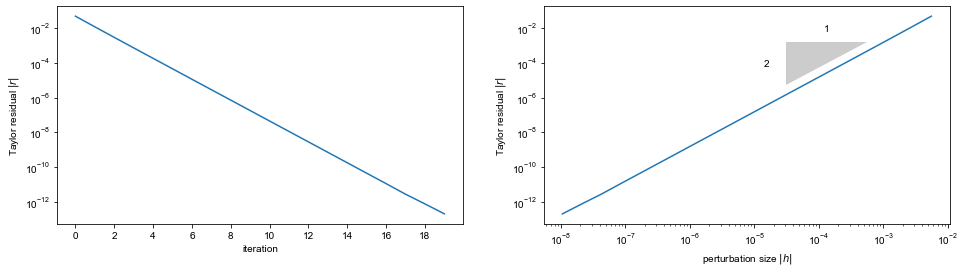

In [237]:
dx = (np.random.random() - 0.5) * 0.02

# if the gradient still remains the same, the writen code is correct
check = taylor_test(fhat, 
                    dfdm, 
                    m, 
                    dx, 
                    max_iter=20, plot_convergence=True, print_convergence=True)